## Inventory Demand Forecasting using Machine Learning

The vendors who are selling everyday items need to keep their stock up to date so, that no customer returns from their shop empty hand. 

A machine learning model will be implemented which can predict the stock amount for the different products which are sold in different stores.

### Importing Libraries and Dataset

Python libraries make it easy for us to handle the data and perform typical and complex tasks with a single line of code.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn import metrics 
from sklearn.svm import SVC  
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error as mae 

import warnings 
warnings.filterwarnings('ignore')


 Load the dataset into the panda’s data frame and print its first five rows.

In [5]:
df = pd.read_csv('/users/macbook/downloads/train.csv') 
display(df.head()) 
display(df.tail())


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


As observed the data has a period of five years for 10 stores and 50 products so, if calculated,  
(365 * 4 + 366) * 10 * 50 = 913000

Confirm if the  calculated size is correct or not .

In [6]:
df.shape

(913000, 4)

The column of the dataset has the following type of data.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


As per the above information regarding the data in each column we can observe that there are no null values.

In [8]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


### Feature Engineering

I will  include an extra feature in my dataset so that I can derive an interesting insight from the data I have. Also, if the feature derived is meaningful, then it becomes a deciding factor in increasing the model’s accuracy significantly.

In [9]:
parts = df["date"].str.split("-", n = 3, expand = True) 
df["year"]= parts[0].astype('int') 
df["month"]= parts[1].astype('int') 
df["day"]= parts[2].astype('int') 
df.head()


,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


Whether it is a weekend or a weekday must have some effect on the requirements to fulfill the demands.

In [10]:
from datetime import datetime 
import calendar 
	
def weekend_or_weekday(year,month,day): 
	
	d = datetime(year,month,day) 
	if d.weekday()>4: 
		return 1
	else: 
		return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1) 
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


 Include a column which can indicate whether there was any holiday on a particular day or not.

In [16]:
from datetime import date
import holidays

def is_holiday(x):
    india_holidays = holidays.country_holidays('IN')
    if india_holidays.get(x):
        return 1
    else:
        return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()


,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


Add some cyclical features.

In [17]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12)) 
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12)) 
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


Add a column whose value indicates which day of the week it is.

In [18]:
def which_day(year, month, day): 
	
	d = datetime(year,month,day) 
	return d.weekday() 

df['weekday'] = df.apply(lambda x: which_day(x['year'], 
													x['month'], 
													x['day']), 
								axis=1) 
df.head()


,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5


 Remove the columns which are not useful 

In [19]:
df.drop('date', axis=1, inplace=True)

### Exploratory Data Analysis

Check what are the relations between different features with the target feature.

In [20]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

As observed there are 10 unique stores and they sell 50 different products.

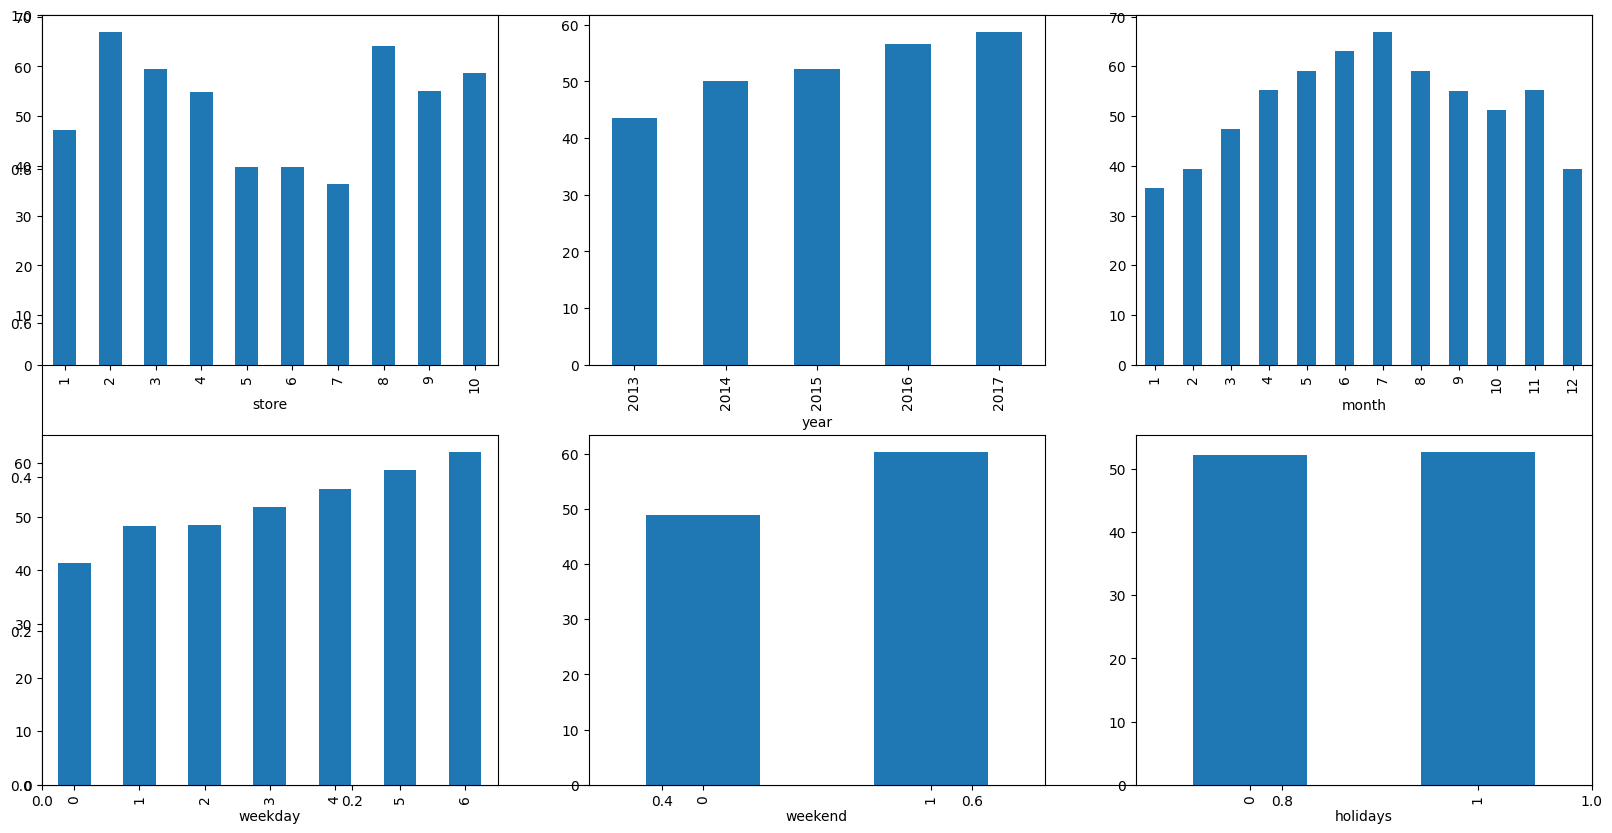

In [22]:
features = ['store', 'year', 'month', \
            'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()


Check the variation of stock as the month closes to the end.

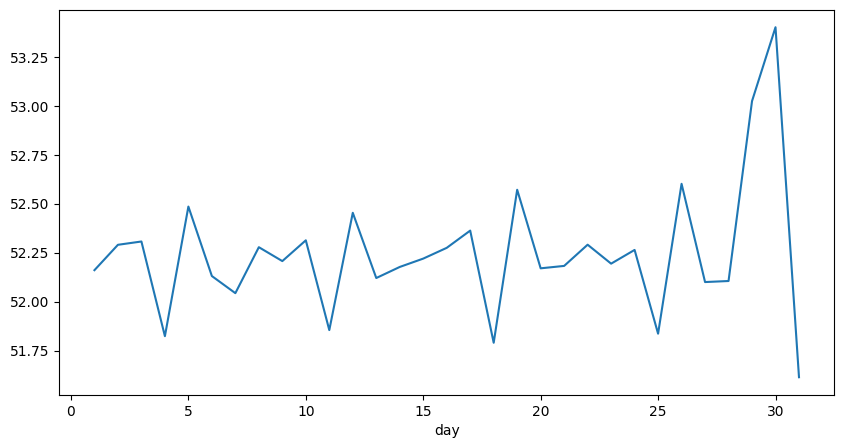

In [23]:
plt.figure(figsize=(10,5)) 
df.groupby('day').mean()['sales'].plot() 
plt.show()

Draw the simple moving average for 30 days period.

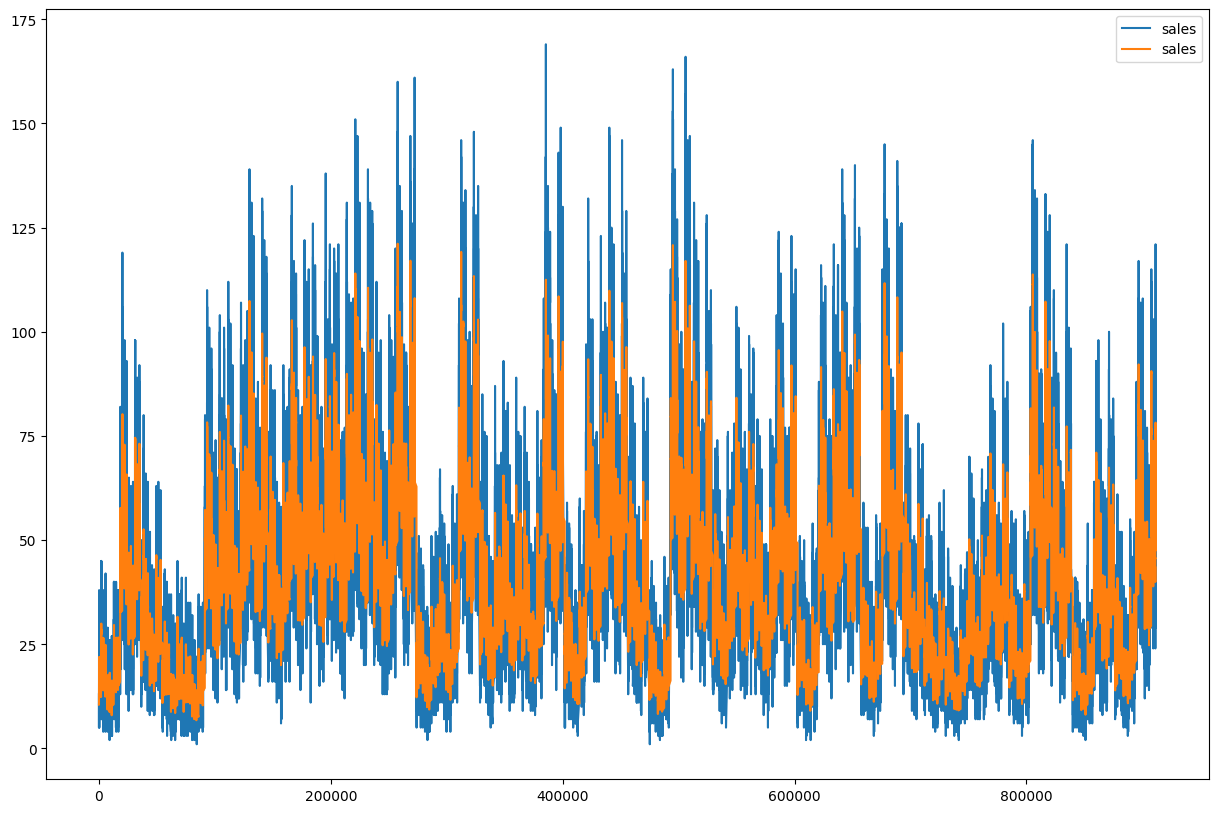

In [24]:
plt.figure(figsize=(15, 10)) 

# Calculating Simple Moving Average 
# for a window period of 30 days 
window_size = 30
data = df[df['year']==2013] 
windows = data['sales'].rolling(window_size) 
sma = windows.mean() 
sma = sma[window_size - 1:] 

data['sales'].plot() 
sma.plot() 
plt.legend() 
plt.show()

As the data in the sales column is continuous, check the distribution of it and also check whether there are some outliers in this column or not.

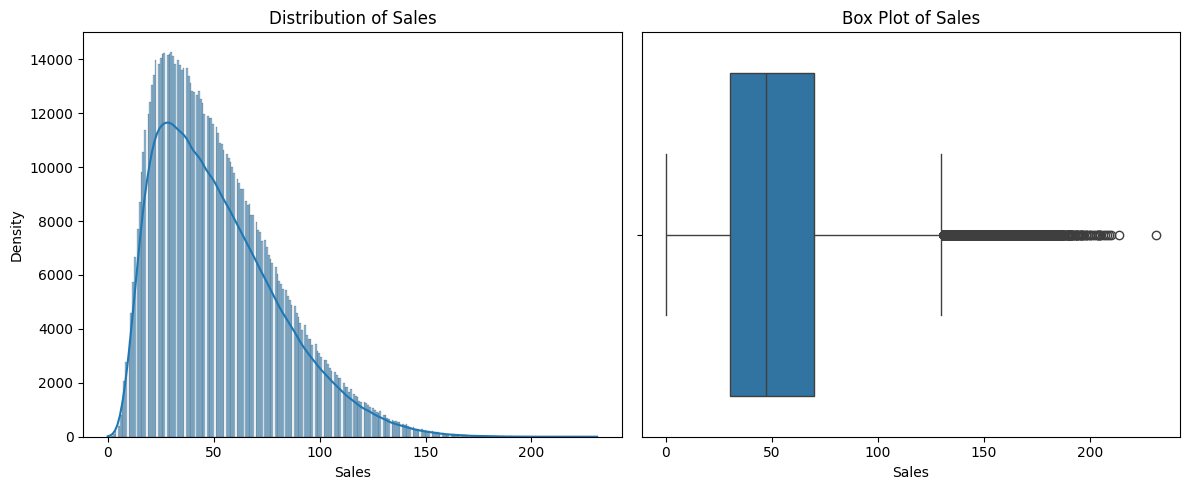

In [27]:
import matplotlib.pyplot as plt
import seaborn as sb

# Set up the figure and axes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sb.histplot(df['sales'], kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sb.boxplot(x=df['sales'])
plt.title('Box Plot of Sales')
plt.xlabel('Sales')

# Show the plots
plt.tight_layout()
plt.show()


Highly correlated features

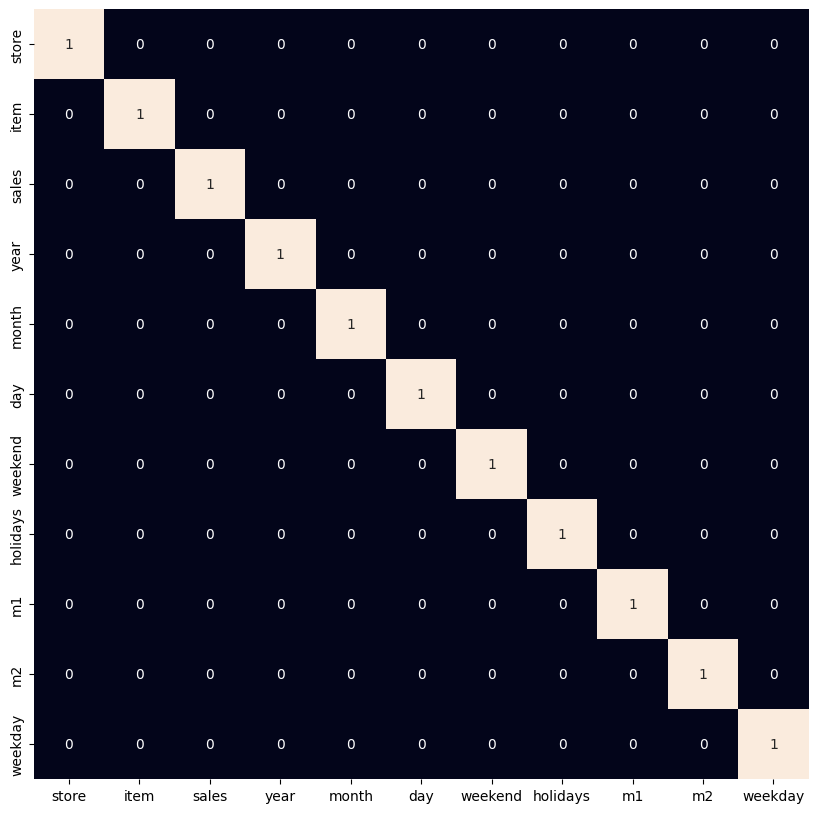

In [28]:
plt.figure(figsize=(10, 10)) 
sb.heatmap(df.corr() > 0.8, 
		annot=True, 
		cbar=False) 
plt.show() 

Remove the outliers which are present in the data.

In [29]:
df = df[df['sales']<140]

### Model Training

Separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [30]:
features = df.drop(['sales', 'year'], axis=1) 
target = df['sales'].values 


X_train, X_val, Y_train, Y_val = train_test_split(features, target, 
												test_size = 0.05, 
												random_state=22) 
X_train.shape, X_val.shape

((861170, 9), (45325, 9))

Normalizing the data before feeding it into machine learning models helps to achieve stable and fast training.

In [31]:
# Normalizing the features for stable and fast training. 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_val = scaler.transform(X_val)

I have split the data into training and validation data also the normalization of the data has been done. Now train some machine learning models and select the best out of them using the validation dataset.

In [36]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error as mae

models = [LinearRegression(), GradientBoostingRegressor(), Lasso(), Ridge()]

for model in models:
    model.fit(X_train, Y_train)
    print(f'{model} : ')
    
    train_preds = model.predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))
    
    val_preds = model.predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()


LinearRegression() : 
Training Error :  20.902989838083602
Validation Error :  20.97163963254154

GradientBoostingRegressor() : 
Training Error :  11.751525907691475
Validation Error :  11.790279548802436

Lasso() : 
Training Error :  21.015028699769758
Validation Error :  21.071517213774968

Ridge() : 
Training Error :  20.902989970366438
Validation Error :  20.97163982226294



The GradientBoostingRegressor significantly outperforms the other models, with both the lowest training and validation errors. This indicates that the Gradient Boosting model is better at capturing the patterns in the data.